#  <center> <span style="color:red"> NLP: WordCloud </span> </center>



### **load necessary packages**

In [1]:
#!pip install -r "..\requirements.txt"

In [2]:
import warnings
#warnings.filterwarnings("error")
warnings.simplefilter(action='ignore', category=FutureWarning) # DeprecationWarning
warnings.simplefilter(action='ignore', category=UserWarning)


import numpy as np
import re
from functools import partial
from unidecode import unidecode

import pandas as pd
pd.set_option("display.max_colwidth", -1) # depracated
pd.options.mode.chained_assignment = None



In [3]:
#pip install -U nltk
#nltk.download('punkt')
#nltk.download('vader_lexicon')

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist

In [4]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
data_path = r"..\data\data.csv"
stop_words_file = r'..\data\additional_stop_words.txt'

In [6]:
df=pd.read_csv(data_path)
print('dataframe shape:', df.shape)

dataframe shape: (74682, 4)


In [7]:
df.sample(3)

,id,entity,sentiment,text
26465,945,AssassinsCreed,Positive,ok this looks interesting I like that hidden blade. Soon to have gameplay soon.
15130,2990,Dota2,Positive,Dota Number 2 after about 6 months let's faking goo
18955,12448,WorldOfCraft,Positive,Look what I did with my cookbook World of Warcraft. They were sooo good. They were hoping to advance even further.


In [8]:
# to make things faster
df=df.sample(10000).reset_index()

---

#  <center> <span style="color:red"> Text Preprocessing </span> </center>


### Using regular expressions
   
<font size='4'>- remove punctuation  
    
<font size='4'>- remove special characters
    
<font size='4'>- remove consecutive spaces

In [9]:

CLEANUP_RULES = [
    partial(re.compile(r'@[^\s]+').sub, ''), # remove pseudos
    partial(re.compile(r'(\r|\t|\n|\\r|\\t|\\n|\r|\t|\n\t|\n\r)').sub, ' '),
    partial(re.compile(r'[^a-zA-Z]+').sub, ' '),  # remove non english alphabetical words (me:non words ! not english)
    partial(re.compile(r'[ \t]*<[^<]*?/?>').sub, ' '),  # remove remaining tags
    partial(re.compile(r'</?.*?>').sub, '<>'),  # remove tags
    partial(re.compile(r'\s+').sub, ' ')  # replace consecutive spaces
    
]

# remove punctuation /     re.sub('@[^\s]+','',Tweet)

In [10]:

def text_cleaner(text):  
    # transformation des caractères avec accent en utf8 - why ? that helps with replacing é with e
    l = text.split()
    t = []
    for word in l:
        try:
            t.append(unidecode(word, 'utf-8'))
        except Exception as e:
            continue

    text = ' '.join(t) # texte initial formater
    
    # néttoyage du texte avec regex
    for rule in CLEANUP_RULES:
        text = rule(text)
        text = text.rstrip()
        text = text.lower()
    
    return text


<font size='4'> **Let's look at a tweet before cleaning:**

In [11]:
df.loc[10]['text']

'CGA do their same - AGAIN. They move up to sole possession at 2nd place, and leave SG and DFM to work away the pieces in their place for our last game of the day. SO. ON.'

In [12]:
df['text'] = df.text.apply(lambda c: text_cleaner(str(c)))

<font size='4'> **and this is what our tweet looks like after the first step in cleaning:**

In [13]:
df.loc[10]['text']

'cga do their same again they move up to sole possession at nd place and leave sg and dfm to work away the pieces in their place for our last game of the day so on'

### remove duplicates

we are going to check for any duplicates and remove them

In [14]:
print('shape before duplicates removal: ',df.shape)

shape before duplicates removal:  (10000, 5)


In [15]:
df = df.drop_duplicates(subset ="text")
print('after :', df.shape)

after : (9522, 5)


In [16]:
df.head()

,index,id,entity,sentiment,text
0,12614,8568,NBA2K,Negative,eliminate the corner please n k i literally have to take the ball away from them otherwise they will open up every time
1,3760,1850,CallOfDutyBlackopsColdWar,Positive,j fuck sleep gotta watch the reveal trailer for cod black ops cold war later at am pic twitter com qostnzf pz
2,29601,690,ApexLegends,Negative,so y all fr just don t care about being terrible these children are
3,66956,7066,johnson&johnson,Neutral,wcuofpa hi johnson johnson has an amazing opening at the summer optomes internship
4,21176,4025,CS-GO,Negative,so i thought the shader changed caused every to be able to see over mollies because one guy abused the fuck out of it every round in wingman and not once could i see him on my screen wtf is this shit csgo


#  <center> <span style="color:red"> Tokenization </span> </center>


<font size='4'> Tokenization consists of cutting or converting a string of characters (a text) into a list of "Token" symbols, most often words, these  are then consumed during parsing

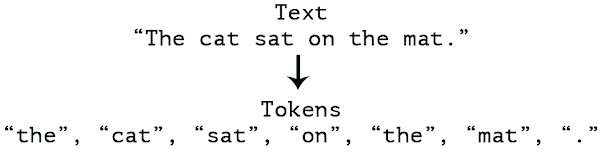

In [17]:
from IPython.display import Image

Image(filename= r'..\images\text-tokens-tokenization-manning.jpg')

In [18]:
corpus = " ".join(df['text'] )
tokens = word_tokenize(corpus)

In [19]:
print('example: ',tokens[:10])

example:  ['eliminate', 'the', 'corner', 'please', 'n', 'k', 'i', 'literally', 'have', 'to']


### Stemming / Lemmatization

<font size='4'>stemming is another solution that allows to only keep the roots of words (not used in this analysis)

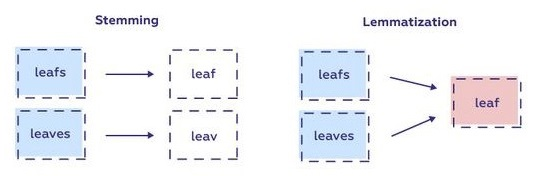

In [20]:
from IPython.display import Image
Image(filename= r'..\images\lemmatization_vs_stemming_i1.jpeg')

In [21]:
stemmer = nltk.stem.SnowballStemmer('english')
stem_text =  lambda text: [stemmer.stem(token) for token in text]

example_words = ['wait', 'waiting', 'waited']
text_stemming_example = stem_text(example_words)
text_stemming_example


['wait', 'wait', 'wait']

**we check the frequency distrbution of our tokens**

In [22]:
fdist = FreqDist()
for word in tokens:
    fdist[word.lower()] += 1
    
fdist.most_common(20) 

[('the', 5770),
 ('i', 4741),
 ('to', 3847),
 ('and', 3482),
 ('a', 3261),
 ('of', 2578),
 ('is', 2343),
 ('it', 2338),
 ('for', 2077),
 ('in', 2051),
 ('this', 1962),
 ('you', 1720),
 ('my', 1605),
 ('on', 1572),
 ('s', 1546),
 ('t', 1524),
 ('that', 1452),
 ('com', 1268),
 ('game', 1180),
 ('with', 1152)]

<font size='4'>most frequent words are pronouns and proposition, which are in fact irrelevant for our analysis.
in order to fix this, we are are going to look how to remove stop words

##  <center> <span style="color:blue"> Remove stop words </span> </center>

<font size='4'> Stop words are basically a set of commonly used words in any language
by removing the words that are commonly used in a given language, we can focus on the important words for our analysis

In [23]:
stop_words = nltk.corpus.stopwords.words('english') #la liste de base de nltk
print('length of stop words: ',len(stop_words))
print(list(stop_words))

length of stop words:  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'ow

###   Let's create an extended list of stop words


In [24]:
with open(stop_words_file, 'r') as f:
    newstopwords = f.readlines()

newstopwords = [x.rstrip() for x in newstopwords]

In [25]:
newstopwords[-10:]

['put', 'here', 'more', 'stop', 'words']

In [26]:
stop_words.extend(newstopwords)

In [27]:
# you are repeating a process you are supposed to do once
# pass on vars as params

def stopwords_removal(clean_text):
    # Tokenization
    text_token= word_tokenize(clean_text) 
    # Filter stopword
     #ajouter la liste supplimentaire à la liste de base de nltk
    filtered_sentence = []
    
    for w in text_token:
        if w not in stop_words:
            filtered_sentence.append(w)
            
    clean_text = ' '.join(filtered_sentence)
    return clean_text


In [28]:
df['cleaned_text'] = df['text'].apply(lambda c: stopwords_removal(c))# Avoir le text sans les stop words


In [29]:
df.head()

,index,id,entity,sentiment,text,cleaned_text
0,12614,8568,NBA2K,Negative,eliminate the corner please n k i literally have to take the ball away from them otherwise they will open up every time,eliminate corner please n k literally take ball away otherwise open every time
1,3760,1850,CallOfDutyBlackopsColdWar,Positive,j fuck sleep gotta watch the reveal trailer for cod black ops cold war later at am pic twitter com qostnzf pz,j fuck sleep got ta watch reveal trailer cod black ops cold war later pic twitter com qostnzf pz
2,29601,690,ApexLegends,Negative,so y all fr just don t care about being terrible these children are,fr care terrible children
3,66956,7066,johnson&johnson,Neutral,wcuofpa hi johnson johnson has an amazing opening at the summer optomes internship,wcuofpa hi johnson johnson amazing opening summer optomes internship
4,21176,4025,CS-GO,Negative,so i thought the shader changed caused every to be able to see over mollies because one guy abused the fuck out of it every round in wingman and not once could i see him on my screen wtf is this shit csgo,thought shader changed caused every able see mollies one guy abused fuck every round wingman could see screen wtf shit csgo


##  <center> <span style="color:blue"> Building the WordCloud </span> </center>

<font size="4"> we prepare our bag of words and then we can check the most common words in our copus again:

In [30]:
corpus = " ".join(df['cleaned_text'] )
#tweets = df_AvantCovid.text.str.cat(sep=' ') #pour concaténer

In [31]:
tokens = word_tokenize(corpus)

#a frequency distribution that encodes how often each word occurs in a text:
from nltk.probability import FreqDist
fdist = FreqDist()
for word in tokens:
    fdist[word.lower()] += 1

In [32]:
fdist.most_common(20)

[('com', 1268),
 ('game', 1180),
 ('like', 640),
 ('pic', 535),
 ('twitter', 526),
 ('get', 506),
 ('one', 498),
 ('good', 468),
 ('play', 455),
 ('love', 454),
 ('new', 445),
 ('really', 423),
 ('johnson', 394),
 ('see', 372),
 ('people', 365),
 ('time', 364),
 ('co', 352),
 ('unk', 342),
 ('shit', 338),
 ('still', 336)]

<font size="4"> as we can see, this time it makes more sense !


**<font size="4"> let's show the word cloud: </font>**

<font size="4">in a word cloud, the size of word expresses the frequency of the word in the bag of words

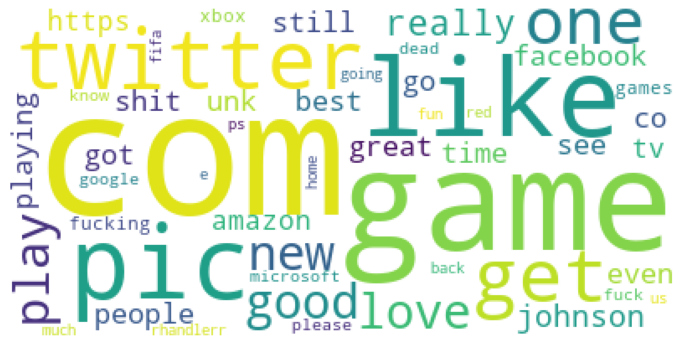

In [33]:
wordcloud = WordCloud(background_color = 'white', 
                      max_words = 50).generate_from_frequencies(fdist)#.generate(str(tweet_corpus))
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

In [34]:

fdist = FreqDist()
for word in tokens:
    fdist[word.lower()] += 1

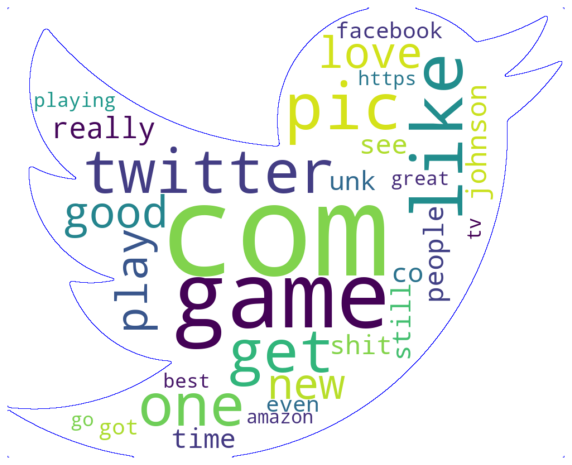

In [35]:
from PIL import Image 

mask = np.array(Image.open("../images/mask.png")) # le masque le logo twitter 
keyword = WordCloud(mask= mask, 
                    max_words=30, 
                    background_color="white", width=2500, height=1800, contour_width=1, 
                    contour_color= 'blue').generate_from_frequencies(fdist)

plt.figure(figsize=[10,10])
plt.imshow(keyword, interpolation="bilinear")
plt.axis("off")
plt.savefig('../images/wordcloud_with_mask.png', dpi=300) # sauvegarder la figure
plt.show()

----